# Introduction

Here we show how to calculate the merger rate density of systems
merging at a single redshift z. By now we assume you understand the indiviual pipelines of;

ClassCOMPAS:

    -- (handling the (mock) data needed)
    
ClassMSSFR:

    -- defining the model for metallicity specific SFR
    
selection_effects:

    -- module to calculate probility detecting a system



Here we show which additional steps are needed for the calculation.
All these steps are done by default in the ClassCosmicIntegrator.
We highlight the steps here outside the function for clarity
since the ClassCosmicIntegrator merely acts as a giant for loop over multiple redshifts and a way to conveniently store the results

# Paths

In [1]:
import os

pathNoteBook    = os.getcwd()
pathScripts     = pathNoteBook + '/PythonScripts/'


pathData        = "/home/cneijssel/Desktop/Test/"


# Imports

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt

from   astropy.cosmology import WMAP9 as cosmology
from   scipy.optimize import newton
#custom scripts
sys.path.append(pathScripts)
import ClassCOMPAS 
import ClassMSSFR  




# 1- Set up data and MSSFR model

In [3]:
# Create instance COMPAS data class

COMPAS = ClassCOMPAS.COMPASData(path=pathData, fileName='COMPAS_output.h5')


Remember to self.setGridAndMassEvolved(), self.setCOMPASDCOmask() and self.setCOMPASData()


In [4]:
#Set the type of DCO of interest and recover their parameters
COMPAS.Mlower = 5
COMPAS.Mupper = 150
COMPAS.binaryFraction =0.7

COMPAS.setGridAndMassEvolved()

COMPAS.setCOMPASDCOmask() #Pessimistic BBHs
COMPAS.setCOMPASData()

Warning no RLOF_SECONDARY_POST_COMMON_ENVELOPE column
I will not mask the data for this
Warning no Optimistic_Common_Envelope column
I will not mask the data for this


In [5]:
# The MSSFR model

#use the metallicityGrid of the Data
metallicityGrid = COMPAS.metallicityGrid

#Create instance Class
MSSFR = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)


In [6]:
#Set the MSSFR model
MSSFR.SFRprescription = 'Neijssel et al. (2019)'
MSSFR.Zprescription = 'logNormal'
MSSFR.logNormalPrescription ='Neijssel Phenomenological'

# 2 - Define the redshifts

The entire calculation depends on defining a redshift
at which the DCOs merge. Then using the delaytimes and astropy
you need to recover when the systems were born

First define our cosmology

In [7]:
# see top notebook

In [8]:
mergerRedshift = 0.2

#Define an age when the first stars formed based on redshift
firstSFR = cosmology.age(10).value
#single value in units of Gyr
ageUniverseAtMergerGyr = cosmology.age(mergerRedshift)
#Recover the array delaytimes in Units of Gyr
delayTimeGyr = np.divide(COMPAS.delayTimes, 1000)
#Calculate the age at which they were born
ageBirth   = ageUniverseAtMergerGyr.value - delayTimeGyr
#If they are born before first SFR mask them
maskUnreal = ageBirth<firstSFR
#I set those to minus 1 to label them
#This way we can use this as a mask everywhere instead of having
#to slice the data in different ways. Useful for larger calculations
ageBirth[maskUnreal] = -1


Note that the above might further reduce the number of DCOs in the data, despite we use the flag merger in a Hubble time. This because that flag assumes redshift is zero. When we change our reference frame to higher redshifts, then the universe is younger and therefore fewer systems will be able to merge in  time

We set the unphysical systems to -1. This because later when we loop over redshifts the number of possible systems can vary. However I want to fill in the rates in a predefined 2D array of fixed shape (nr systems, nr of redshift bins). Hence I assume the largest array (size of nr of DCOs) and set the rate to zero in case.  Note that the MSSFR script also depends on the mask of systems being unreal of -1. (see returnMSSFR())

To recover the redshift it is a bit tricky. Astropy can quicly
calculate the age from redshift, but the inverse is more difficult.
In the code we use look up the nearest value in a dense precalculated table.
Here we use a older method to calculate (for credits see source code classCosmicintegrator) which is considerably slower. 

In [9]:
redshiftsBirth = np.zeros(len(ageBirth))
for nr, age in enumerate(ageBirth):
    if age != -1:
        redshiftsBirth[nr] = newton(lambda x: cosmology.age(x).value-age, 0)
        
    else:
        redshiftsBirth[nr] = -1

In [10]:
print("nr of DCOs %s, nr DCOs merging %s"\
     %(len(COMPAS.delayTimes), np.sum(ageBirth!=-1)))


nr of DCOs 77, nr DCOs merging 77


# Calculate the rate of systems per metallicity

The code is structured to do the calculation per subpopulation of DCOs of a single metallicity. Note that if the system was not physically possible (age == -1) then the rate is set to zero.

In [11]:
#create an array for rate per system merging at redshift z
ratePerSystem = np.zeros(len(COMPAS.delayTimes))

In [12]:
for nrZ, Z in enumerate(metallicityGrid):
    maskZ    = COMPAS.metallicitySystems == Z
    #give MSSFR per system which has metallicity Z [Msun/dGpc3/dyr]
    mssfr    = MSSFR.returnMSSFR(metallicity=Z,\
                                 agesBirth  =ageBirth[maskZ],
                                 redshiftBirth=redshiftsBirth[maskZ])
    #Calculate rate using amount of Msun evolved [dN/dGpc3/dyr]
    RatesZ   = np.divide(mssfr, COMPAS.totalMassEvolvedPerZ[nrZ])
    #Fill the rates in the defined array according to mask
    ratePerSystem[maskZ] = RatesZ

In [13]:
print(metallicityGrid)

[0.0035]


In [14]:
print(ratePerSystem)

[0.56829602 0.56805516 0.71716238 0.56332887 0.64235031 0.56572458
 2.6326764  0.57115619 0.56857636 1.22723656 0.56492981 2.03983155
 0.56955651 0.56907558 0.56881638 0.57024149 0.57764799 0.56847057
 1.18959653 0.5720944  2.05286382 0.57549406 0.56650635 0.56503152
 0.56417876 0.56650706 0.56420968 0.57027018 0.57061306 0.56442467
 0.5666502  3.11845934 0.57014187 0.57501391 1.05787896 0.75992594
 0.56577033 0.56434755 0.57071508 0.85101206 0.56862866 1.26211703
 0.56582486 0.61593553 0.56394581 0.56485369 0.56958189 0.56809065
 0.68331022 0.6352792  0.92401503 1.05188824 0.56950327 0.5664708
 0.57786102 0.5629744  0.56588836 1.20627081 0.56757245 0.56338008
 0.56320611 0.56475243 0.57233615 0.58453683 0.63303028 0.71863588
 0.566297   0.56403287 2.70936728 0.57381387 0.57446459 0.56459357
 0.67291101 0.56544547 0.56707128 0.65660322 0.59074576]


In [15]:
print(np.sum(ratePerSystem))

58.77007362116013


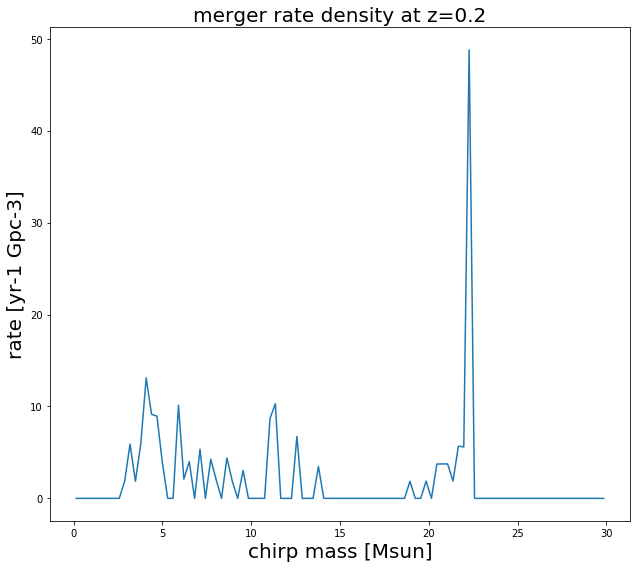

In [16]:
# Using the rates in a histogram

chirpMasses = COMPAS.mChirp

binsM = np.linspace(0,30,100)
dM    = np.diff(binsM)
center= (binsM[1:]+binsM[:-1])/2.

#remember that the reight is essentially a weight per system

y , _     = np.histogram(chirpMasses, bins=binsM, \
                     weights=ratePerSystem)

dydMchirp = np.divide(y, dM)

fig, axes = plt.subplots(1,1, figsize=(9,8))
axes.plot(center, dydMchirp)
axes.set_xlabel('chirp mass [Msun]', fontsize=20)
axes.set_ylabel('rate [yr-1 Gpc-3]', fontsize=20)
axes.set_title('merger rate density at z=%s'\
               %(mergerRedshift), fontsize=20)
plt.tight_layout()
plt.show()


Now here we only have the chirp mass distribution at a single redshift
per unit volume. The next step is to do it over a range of redshifts
and get the absolute rates.